# **Sujet : Reconnaissance de caractères**
<p>Développer un code pour détecter des caractères.<p>

<br>https://francescopochetti.com/text-recognition-natural-scenes/

In [ ]:
import os
from google.colab import drive
drive.mount('drive')
!mkdir -p drive -v
cwd = os.getcwd()

Mounted at drive


In [89]:
import math
import matplotlib.pyplot
import numpy
import pandas
import skimage
import scipy
import sklearn

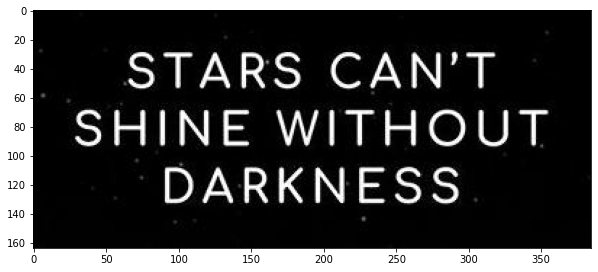

In [ ]:
from skimage.io import imread

# img = imread('drive/My Drive/Colab Notebooks/lao.jpg', as_gray=True) # lecture de l'image image01.png
img = imread('drive/My Drive/Colab Notebooks/image04.jpg', as_gray=True) # lecture de l'image image01.png
matplotlib.pyplot.figure(figsize=(10, 10)) # visualisation
matplotlib.pyplot.imshow(img, cmap='gray') # visualisation de l'image img_01_gray.png

1. **Denoising** : <br>This is done applying a <a href="https://en.wikipedia.org/wiki/Total_variation_denoising">**total variation approach**</a> which consists in reducing as much as possible the integral of the absolute gradient of the image, where the gradient of an image can simply be interpreted as a directional change in the intensity or color in the image itself.
<br>http://gael-varoquaux.info/scipy-lecture-notes/advanced/image_processing/auto_examples/plot_face_tv_denoise.html

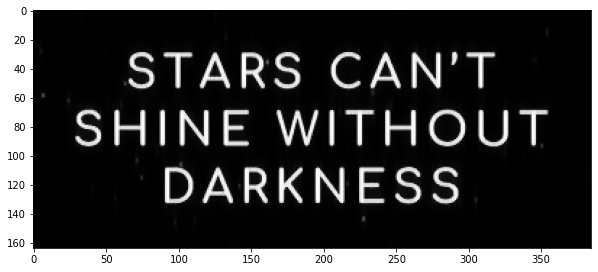

In [ ]:
from skimage.restoration import denoise_tv_chambolle

img_tvDenoised = denoise_tv_chambolle(img, weight=0.1, multichannel=True) # Using total variation filter denoising
matplotlib.pyplot.figure(figsize=(10, 10)) # visualisation
matplotlib.pyplot.imshow(img_tvDenoised, cmap='gray') # visualisation de l'image img_tvDenoised.png

2. **Increasing Contrast** : <br>This is done applying <a href="https://en.wikipedia.org/wiki/Otsu%27s_method">**Otsu‘s method**</a> which calculates an “optimal” threshold by maximizing the variance between two classes of pixels,  separated by the threshold. Equivalently, this threshold minimizes the intra-class variance.
<br>https://www.meccanismocomplesso.org/en/opencv-python-the-otsus-binarization-for-thresholding/
<br>https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html

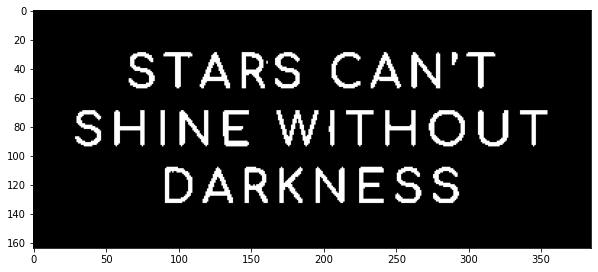

In [ ]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(img_tvDenoised)
img_binary = img_tvDenoised > thresh

matplotlib.pyplot.figure(figsize=(10, 10)) # visualisation
matplotlib.pyplot.imshow(img_binary, cmap='gray')

3. **Object Detection** : Contours are identified and a rectangle is drawn around objects candidates.
<br>https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html
<br>https://scikit-image.org/docs/0.8.0/api/skimage.measure.find_contours.html
<br>https://muthu.co/draw-bounding-box-around-contours-skimage/

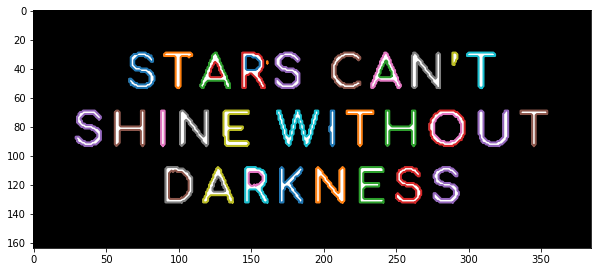

In [ ]:
from skimage.measure import find_contours

# Find contours at a constant value of 0.5
contours = find_contours(img_binary, level=0.8)

# Display the image and plot all contours found
matplotlib.pyplot.figure(figsize=(10, 10)) # visualisation

for contour in contours:
  matplotlib.pyplot.plot(contour[:, 1], contour[:, 0], linewidth=2)

matplotlib.pyplot.imshow(img_binary, cmap='gray')
# matplotlib.pyplot.gca().invert_yaxis()

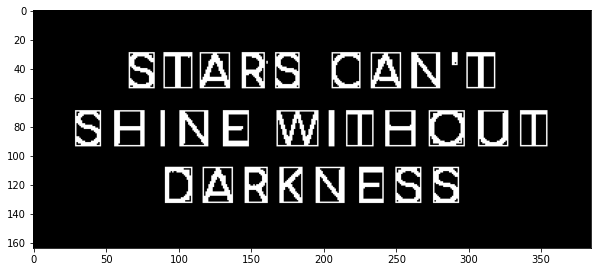

In [ ]:
from skimage.draw import polygon_perimeter
# from skimage.util import invert

bounding_boxes = []
img_with_boxes = numpy.copy(img_binary)

# contours = 38
for contour in contours:
  Xmin = numpy.min(contour[:, 0])
  Xmax = numpy.max(contour[:, 0])
  Ymin = numpy.min(contour[:, 1])
  Ymax = numpy.max(contour[:, 1])
  
  bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
  # print([int(Xmin), int(Xmax), int(Ymin), int(Ymax)])

for box in bounding_boxes:
  # [Xmin, Xmax, Ymin, Ymax]
  r = [box[0], box[1], box[1], box[0], box[0]]
  c = [box[3], box[3], box[2], box[2], box[3]]
  
  rr, cc = polygon_perimeter(r, c, img_with_boxes.shape)
  img_with_boxes[rr, cc] = 1 # set color white

# with_boxes = invert(with_boxes)

matplotlib.pyplot.figure(figsize=(10, 10)) # visualisation
matplotlib.pyplot.imshow(img_with_boxes, cmap="gray")

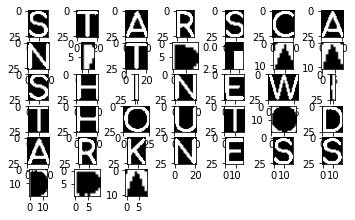

In [ ]:
from math import ceil, floor

fig = matplotlib.pyplot.figure()

for box in range(len(bounding_boxes)):
  nb_subplot = ceil(math.sqrt(len(bounding_boxes))) # if we have 38 images, we output 7*7 subplot
  ax = fig.add_subplot(nb_subplot, nb_subplot, box+1)
  # img_binary[rect_bottom:rect_top, rect_left:rect_right]
  img_patch = img_binary[floor(bounding_boxes[box][0]):ceil(bounding_boxes[box][1]), floor(bounding_boxes[box][2]):ceil(bounding_boxes[box][3])]
  ax.imshow(img_patch, cmap="gray")

4. **Text Detection** : The challenge now is to detect which ones of the identified objects contain text in order to be able to classify it. Basically I have to train a model to make such a decision which means that first of all I need a proper dataset, consisting ideally of half images containing text and half not containing it.<br>
(1) I took 50k images from the 78903 available in the <a href="http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/">74K Chars dataset</a>. This is the half containing text and I labeled each image as a 1.<br>
(2) I took all the 50k images in the <a href="https://www.kaggle.com/c/cifar-10/data">CIFAR-10 dataset on Kaggle</a>. This is the half NOT containing text and I labeled each image as a 0.<br>
(3) The complete dataset was then composed of 100k images, properly labeled and randomly shuffled. Then I needed a model to perform the binary classification.
<br>https://devendrapratapyadav.github.io/Chars74k_Recognition/
<br>https://github.com/DevendraPratapYadav/Chars74k_Recognition
<br>https://github.com/mitchellvitez/chars74k/blob/master/chars74k.py